# Lab №10. Деревья решений

**План занятия**

* [Теоретическая часть](#theory)
    * [Деревья решений](#dt)
    * [Построение деревьев решений](#build_dt)
        * [Критерий информативности](#criterion)
        * [Критерии останова](#stop)
    * [Реализация дерева решений](#implement_dt)
    * [Работа деревьев в случае пропущенных значений](#nan)
    * [Работа деревьев с категориальными признаками](#cats)
* [Домашнее задание](#hw)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

## Деревья решений<a class="anchor" id="dt"></a>

В этом уроке пойдет речь еще об одном популярном методе машинного обучения - _деревьях решений_. Это семейство алгоритмов значительно отличается от линейных моделей, но применяется также в задачах классификации и регрессии.

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

1. Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

2. Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

3. Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

<img src="L4_graphviz.png" width="800">

<h1 style="color:black" align="center">Решающие деревья</h1>

<h1 style="color:#008B8B">1. Определение решающего дерева</h1>

Рассмотрим бинарное дерево, в котором:

* каждой внутренней вершине $v$ приписана функция (или предикат) $\beta_v: \mathbb{X} \to \{0, 1\}$;

* каждой листовой вершине $v$ приписан прогноз $c_v \in Y$ 

в случае с классификацией листу также может быть приписан вектор вероятностей:

$\large c_v \in \mathbb{R}_{+}^{k}, \sum\limits_{k=1}^K c_{v_k} = 1$ 


Рассмотрим теперь алгоритм $a(x)$, который стартует из корневой вершины $v_0$ и вычисляет значение функции $\beta_{v_0}$. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую, вычисляет значение предиката в новой вершине и делает переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина; алгоритм возвращает тот класс, который приписан этой вершине. Такой алгоритм называется - *бинарным решающим деревом*.

На практике в большинстве случаев используются одномерные предикаты $\beta_v$, которые сравнивают значение одного из признаков с порогом:

$\large \beta_v(x; j, t) = [x_j < t].$

Существуют и многомерные предикаты, например:

* линейные $\beta_v(x) = [\langle w, x \rangle < t]$;

* метрические $\beta_v(x) = [\rho(x, x_v) < t]$, где точка $x_v$ является одним из объектов выборки любой точкой признакового пространства. $\rho(x, x_v)$ - расстояние от объекта $x$ до объекта $x_v$.

Многомерные предикаты позволяют строить ещё более сложные разделяющие поверхности, но очень редко используются на практике - например, из-за того, что усиливают и без того выдающиеся способности деревьев к переобучению. Далее мы будем говорить только об одномерных предикатах.

<h1 style="color:#008B8B">2. Построение деревьев</h1>

### Жадное построение дерва

Опишем базовый жадный алгоритм построения бинарного решающего дерева. Запишем алгоримт:

Имеется функция $\text{BulidNode}(m, R_m):$, которая на вход принимает номер вершины $m$ и объекты которые попали в данную вершину $R_m$. Функция будет запускаться с аргументами $\text{BulidNode}(1, X)$, где $X$ - это вся обучающая выборка.

**Шаг 1.** Проверяем, необходимо ли продолжать построение дерева. Есил выполнен критерий остановы: 

* тогда считаем прогноз $c_m$ и завершаем работу объявив вершину листовой.

**Шаг 2.** Иначе, необходимо продолжить разбиение. Тогда необходимо найти оптимальный предикат, в качестве предиката мы будем использовать $[x_j < t]$, значит необходимо найти оптимальные $j, t$ - запишем это как:

$$\large j, t = \underset{\substack{j = 1, \ldots, d \\t}}{\text{arg max}} \quad Q(R_m, j, t)$$ - Выполняем $\text{arg max}$ по всем признакам $j$ и по всем порогам $t$, считаем значение функционала качества предиката. Другими словами мы выполняем полный перебор всех признаков, всех порогов и берем ту пару, на которой значение функционала качества для предиката максимальное.
    
Значит, дальше необходимо выполнить разбиение: Множество объектов, которые пойдут влево $R_{\ell} = \{(x, y) \in R_{m} | [x_{j} \le t]\}$, а вправо $R_{r} = \{(x, y) \in R_{m} | [x_{j} > t]\}$

**Шаг 3.** Запускаем функцию  для левого поддерева $\text{BulidNode}(l, R_{\ell})$ и правого поддерева $\text{BulidNode}(r, R_{r})$
    

**Критерии останова:**

* Для задачи классификации  - если среди всех объектов, которые попали в вершину $R_m$, содержатся объекты только одного класса, тогда можно остановиться.

* Если достигнута максимальная глубина

* Если мощность меньше $|R_m| < K$, то есть, если в $R_m$ содержится мало объектов, тогда нет смысла продолжать разбиение. 


**Как посчитать прогноз $c_m$?**

Если мы вершину $c_m$ объявляем листовой, значит, дальше не разбиваем, так как это лист, тогда необходимо выдавать некоторый прогноз на листе:

* Для задачи классификации - выдаем самый популярный класс в $R_m$

* Для задачи классификации - выдаем распределение классов в $R_m$

* Для задачи регрессии - выдаем среднее значение по $R_m$

**Какие пороги рассматриваем?**

Берем $j$-й признак и сортируем все объекты по значению данного признака $x_{1 j} \le \ldots \le x_{\ell j}$. Тогда берем все промежуточные пороги (между каждой парой). Но не понятно какое значение порога брать, можем вспомнить идею о SVM, что нет необходимости делать лишних предположения о данных, разделяя выборки на пополам. Значит мы возьмем все попроги между значениями признаков $t_{1} = \frac{x_{1 j} + x_{2 j}}{2}, \ldots$. 

Из-за большого количества объектов, количество порогов будет огромным и перебор для разбиеня усложниться, так как мы находимо оптимальную пару из $j, t$. Соответственно, для отсортированных значений признаков $x_{1 j} \le \ldots \le x_{\ell j}$ и использовать в качестве порога перцентили, например 100 штук.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./cardio.csv', sep=';')

features = ['age', 'gender', 'height']
target = ['cardio']
df = df.iloc[:5][features + target]
df

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1
4,47,1,156,0


In [3]:
df[(df.age <= 1)]

,age,gender,height,cardio


In [4]:
df[~(df.age <= 1)]

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1
4,47,1,156,0


In [5]:
df['height'].unique()

array([168, 156, 165, 169], dtype=int64)

<h1 style="color:#008B8B">3. Критерии информативности</h1>

Введем функцию $H(R)$, которая считается конкретно для вершины дерева - это критерий информативности / мера хаотичности вершины (impurity criterion). Это функция показыват насколько неоднородно распределение целевой переменной в этой верщине.

Усрединм по всем объектам, которые попали в множество $R$ и посчитаем ошибку при прогнозировании некоторой константой $c$ и возьмем минимум по всем таким констатам $c$:

$$\large H(R) = \min_{c \in \mathbb{Y}} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} L(y_i, c)$$

Представляем, что эта вершина $R$ будет являться листой и дальше мы ее не будем разбивать, тогда мы должны на этой вершине выдавать константный прогноз. Поэтому мы перебираем все возможные константные прогнозы в этой вершине и для каждого констангного прогноза измеряем то, насколько он ошибается, какова ошибка константного прогноза на выборке $R$ и выберем такой константный прогноз при котором ошибка будет минимальна, это будет значением impurity.

Если мы решаем задачу классификации и в нашей вершине три положительных объекта, тогда если взять константу $c = +1$, то значение функции потерь будет нулевое и impurity тоже будет равен $H(R) = 0$. А если вершина будет разнородная (в вершине как положительные, так и отрицательные объекты), тогда для любой константы значение $H(R)$ окажется больше.

<h2 style="color:#008B8B">3.1 Регрессия</h2>

Как обычно, в регрессии выберем квадрат отклонения в качестве функции потерь $L(y, c) = (y - c)^2$. В этом случае критерий информативности будет выглядеть как:

$$\large H(R) = \min_{c \in \mathbb{Y}} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$

Как известно, минимум в этом выражении будет достигаться на среднем значении целевой переменной. Мы значем, что в такой функции оптимальны прогноз $c$ это среднее значение $y$ по всей выборке $R$, запишем как $c = \frac{1}{|R|} \sum\limits_{(x_i, y_i) \in R} y_i = \bar{y}$, тогда $H(R)$ считается как:

$$\large H(R) = \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - \bar{y})^2$$

Мы получили, что информативность вершины измеряется её дисперсией — чем ниже разброс целевой переменной, тем лучше вершина. Разумеется, можно использовать и другие функции ошибки L — например, при выборе абсолютного отклонения мы получим в качестве критерия среднее абсолютное отклонение от медианы.

Если в вершине находится три объекта с одним значением целевой переменной, тогда дисперсия в этой выборке будет равна 0.

In [6]:
df

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1
4,47,1,156,0


In [7]:
df[(df.cardio <= 0.5)]

,age,gender,height,cardio
0,50,2,168,0
4,47,1,156,0


In [8]:
df[~(df.cardio <= 0.5)]

,age,gender,height,cardio
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1


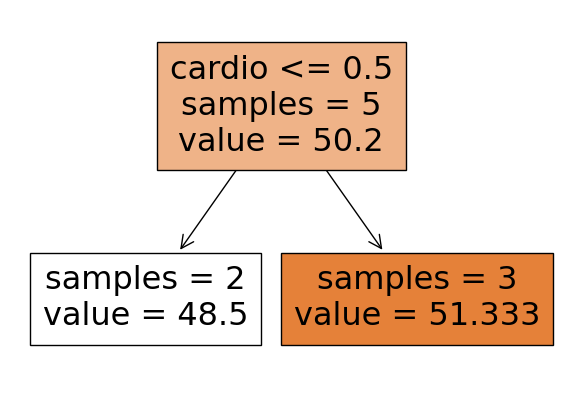

In [9]:
dt_regr = DecisionTreeRegressor(random_state=1, max_depth=1)

features = ['cardio', 'gender', 'height']
target = ['age']

dt_regr.fit(df[features], df[target])

fig, ax = plt.subplots(figsize=(7, 5))
plot_tree(dt_regr, ax=ax, feature_names=list(features), filled=True, impurity=False);

<h2 style="color:#008B8B">3.2 Классификация</h2>

Обозначим через $p_{k}$ долю объектов класса $k$ ($k \in \{1, \dots, K\}$), попавших в вершину $R$:

$\large p_{k} = \frac{1}{|R|} \sum\limits_{(x_i, y_i) \in R} [y_i = k].$

Через $k_*$ обозначим класс, чьих представителей оказалось больше всего среди объектов, попавших в данную вершину: $k_* = \underset{\substack{k}}{\text{arg max}} p_{k}$.

### 3.2.1 Ошибка классификации

Рассмотрим индикатор ошибки как функцию потерь $L(y, c) = [y \ne c]$:

$$\large H(R) = \min_{c \in \mathbb{Y}} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} [y \ne c]$$

Легко видеть, что оптимальным предсказанием тут будет наиболее популярный класс $k_{*}$ — значит, критерий будет равен следующей доле ошибок:

$$\large H(R) = \min_{c \in \mathbb{Y}} \frac{1}{|R|} \sum_{(x_i, y_i) \in R} [y \ne k_{*}] = 1 - p_{k_{*}}$$

Данный критерий является достаточно грубым, поскольку учитывает частоту $p_{k_{*}}$ лишь одного класса. Например, у вершины находится 3 крестика и 3 нолика, тогда мы получим $H(R) = \frac{1}{2}$. В лучшем случае можно добавить ещё один предикат и провести разбиение, после чего можно будет остановиться. А если будет 3 крестика и ещё 3 объекта других классов, тогда $H(R) = \frac{1}{2}$, когда более информативный критерий будет выше. Но для нашей модели первый вариант был лучше, так как у второго варианта несколько классов и за одно разбиение будет сложно разделить классы.

In [10]:
df

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1
4,47,1,156,0


In [11]:
df[(df.age <= 47.5)]

,age,gender,height,cardio
4,47,1,156,0


In [12]:
df[~(df.age <= 47.5)]

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1


In [13]:
features

['cardio', 'gender', 'height']

In [14]:
features = ['age', 'gender', 'height']

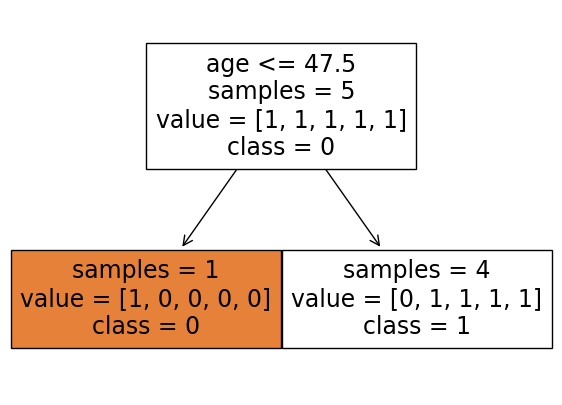

In [15]:
dt_clsf = DecisionTreeClassifier(random_state=1,
                                 max_depth=1)

features = ['age', 'gender', 'height']
target = ['age']
dt_clsf.fit(df[features], df[target])

fig, ax = plt.subplots(figsize=(7, 5))
plot_tree(dt_clsf, ax=ax, feature_names=list(features), class_names=['0', '1'], filled=True, impurity=False);

## Выбор лучшего предиката

При построении дерева необходимо задать *функционал качества*, на основе которого осуществляется разбиение выборки на каждом шаге. Обозначим через $R_m$ множество объектов, попавших в вершину, разбиваемую на данном шаге, а через $R_\ell$ и $R_r$ - объекты, попадающие в левое и правое поддерево соответственно при заданном предикате.

Мы будем использовать функционалы следующего вида:

$$\large Q(R_m, j, t)
=
H(R_m)
-
\frac{|R_\ell|}{|R_m|}
H(R_\ell)
-
\frac{|R_r|}{|R_m|}
H(R_r).$$

**Пояснение функционала**

Считаем хаотичность до разбиения и считаем хаотичность для каждой из вершин после разбиения, и чем больше разница между хаотичность родитеьской вершины и дочерних вершин, тем лучше данный предикат.

**Вид формулы:**

$H(R_m)$ можно не записывать в этой задаче и тогда перепишем в формул в следующем виде, которую будем минимизировать:

$$\large Q(R_m, j, t)
=
\frac{|R_\ell|}{|R_m|}
H(R_\ell)
+
\frac{|R_r|}{|R_m|}
H(R_r).$$


Здесь $H(R)$ - *это критерий информативности (impurity criterion)*, который оценивает качество распределения целевой переменной среди объектов множества $R$. Чем меньше разнообразие целевой переменной, тем меньше должно быть значение критерия информативности - и, соответственно, мы будем пытаться минимизировать его значение. Функционал качества $Q(R_m, j, s)$ мы при этом будем максимизировать.

### Критерий информативности<a class="anchor" id="criterion"></a>

В задаче **классификации** есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Энтропийный критерий_ или _энтропия Шеннона_ :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

[Энтропия и деревья принятия решений](https://habr.com/ru/post/171759/)
<img src='entropy.png'>

In [16]:
blue = 9
yellow = 11
total = blue + yellow

p_blue = blue / total
p_yellow = yellow / total
p_blue, p_yellow

(0.45, 0.55)

In [17]:
e0 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e0

0.9927744539878083

Энтропия левой группы:

In [18]:
blue = 8
yellow = 5
total1 = blue + yellow

p_blue = blue / total1
p_yellow = yellow / total1
p_blue, p_yellow

(0.6153846153846154, 0.38461538461538464)

In [19]:
e1 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e1

0.9612366047228759

Энтропия правой группы:

In [20]:
blue = 1
yellow = 6
total2 = blue + yellow

p_blue = blue / total2
p_yellow = yellow / total2
p_blue, p_yellow

(0.14285714285714285, 0.8571428571428571)

In [21]:
e2 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e2

0.5916727785823275

In [22]:
ig = e0 - total1 / total * e1 - total2 / total * e2
ig

0.16088518841412436

**Реализуем критерий информативности Джини**

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [23]:
# Расчет критерия Джини

def gini(labels):
    labels = list(labels)

    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    gini = 1
    for label in classes:
        p = classes[label] / len(labels)
        gini -= p ** 2
        
    return gini

In [24]:
def gini(labels):
    labels = list(labels)
    set_labels = set(labels)
    
    gini = 1
    for label in set_labels:
        p = labels.count(label) / len(labels)
        gini -= p ** 2
        
    return gini 

In [25]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [26]:
df

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1
4,47,1,156,0


In [27]:
gini0 = gini(df['cardio'])
gini0

0.48

In [28]:
t = 47.5

In [29]:
df1 = df[df['age'] <= t]
df2 = df[df['age'] > t]

In [30]:
df1

,age,gender,height,cardio
4,47,1,156,0


In [31]:
gini(df1['cardio'])

0.0

In [32]:
df2

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
3,48,2,169,1


In [33]:
gini(df2['cardio'])

0.375

In [34]:
features

['age', 'gender', 'height']

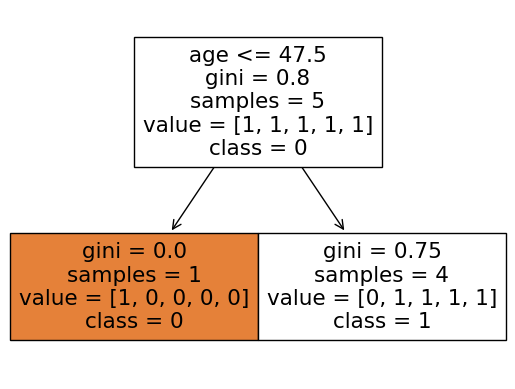

In [35]:
features = ['age', 'gender', 'height']
plot_tree(dt_clsf, feature_names=list(features), class_names=['0', '1'], filled=True, impurity=True);
plt.show()

In [36]:
gain(df1['cardio'], df2['cardio'], gini0, gini)

0.17999999999999994

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

или же *среднеабсолютным отклонением*:

$$H(X) = \frac{1}{X}\sum_{i\in X}(|y_{i} - \bar{y}(X)|),$$


где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

**Реализуем критерий информативности среднеквадратичного отклонения**

In [37]:
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)
    
mse(df['age'])

7.760000000000001

In [38]:
df1 = df[df['height'] <= 168]

In [39]:
df1

,age,gender,height,cardio
0,50,2,168,0
1,55,1,156,1
2,51,1,165,1
4,47,1,156,0


In [40]:
mse(df1['age'])

8.1875

In [41]:
df2 = df[~(df['height'] <= 168)]

In [42]:
mse(df2['age'])

0.0

In [43]:
df2

,age,gender,height,cardio
3,48,2,169,1


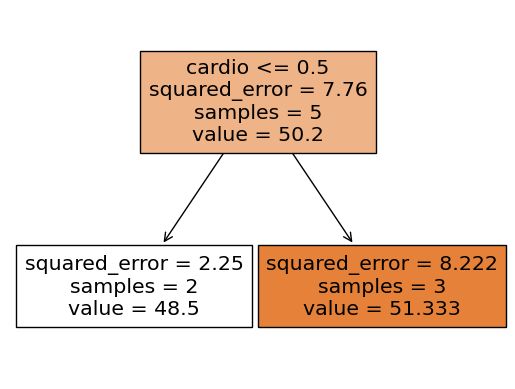

In [44]:
features = ['cardio', 'gender', 'height']
plot_tree(dt_regr, feature_names=list(features), filled=True, impurity=True);

In [45]:
gain(df1['age'], df2['age'], mse(df['age']), mse)

1.21

### Критерии останова<a class="anchor" id="stop"></a>

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе.


- Останов в случае, когда все объекты в листе относятся к одному классу.


Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

## Реализация дерева решений<a class='anchor' id='implement_dt'>

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [46]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=50, random_state=5)

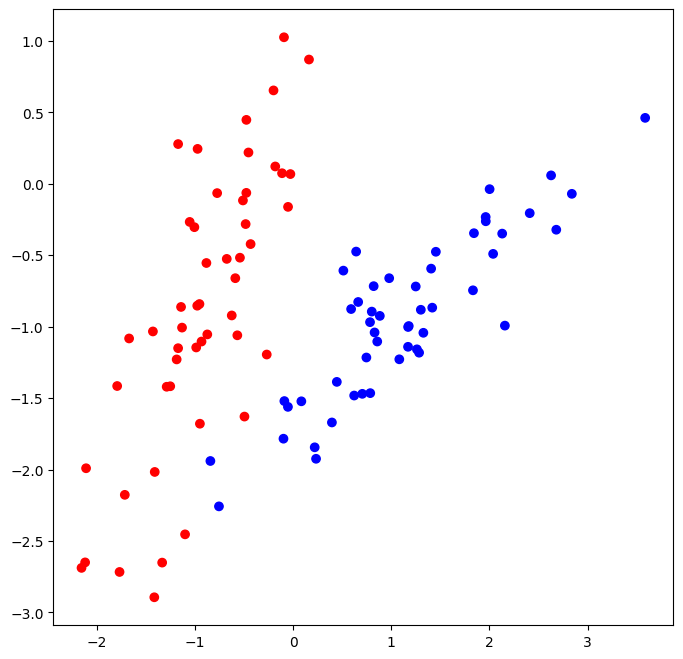

In [47]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [48]:
# Реализуем класс узла

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [49]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [50]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [51]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [52]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [53]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 1

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [54]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [55]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [56]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [57]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [58]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [59]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.4942656820712277
      --> True:
        Индекс 0 <= -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [60]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [61]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [62]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [63]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [64]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

In [115]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    print(mesh_predictions.shape)
    print(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

(632, 714)
(632, 714)


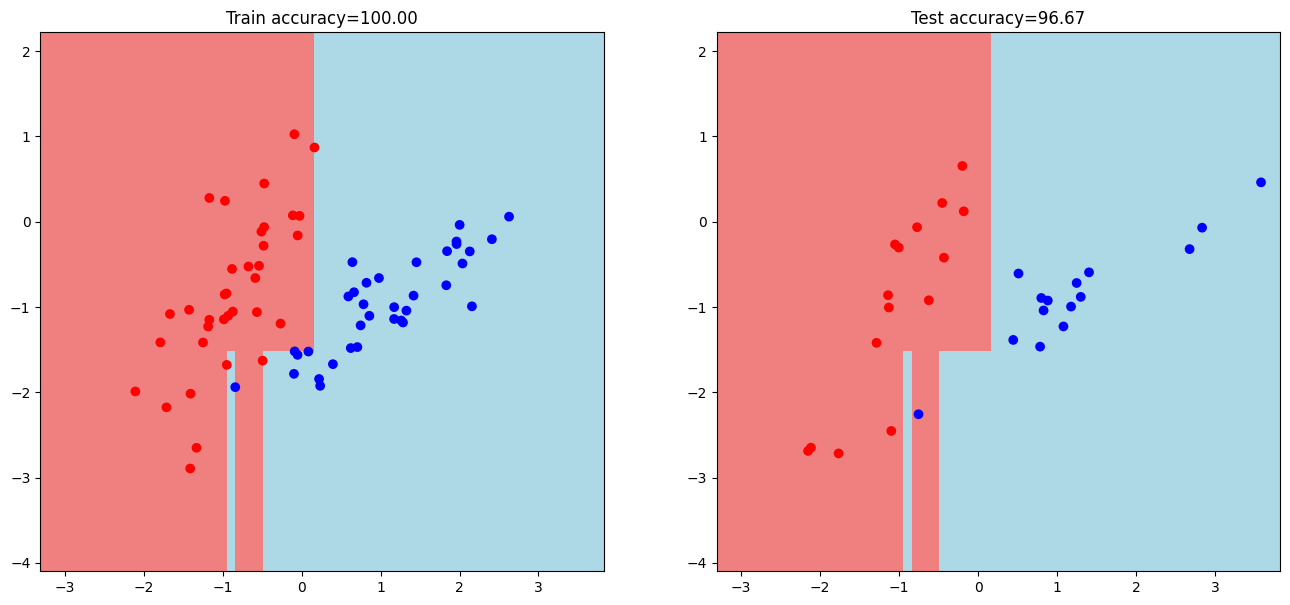

In [116]:
visualize(train_data, test_data)


Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

### Пример с датасетом сердечно-сосудистых заболеваний

In [67]:
import pandas as pd
df_full = pd.read_csv('./data/cardio.csv', sep=';')

features = ['age', 'height']
target = ['cardio']

df = df_full[features + target]
print(df.shape)

train_data, test_data, train_labels, test_labels = train_test_split(df[features].values, 
                                                                    np.squeeze(df[target].values),
                                                                    test_size=0.3,
                                                                    random_state=1)

FileNotFoundError: [Errno 2] No such file or directory: './data/cardio.csv'

In [ ]:
%%time

my_tree = build_tree(train_data, train_labels)

Wall time: 7 ms


In [ ]:
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.4942656820712277
      --> True:
        Индекс 0 <= -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [ ]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [ ]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 100.0
Test accuracy 96.66666666666667


Wall time: 357 ms


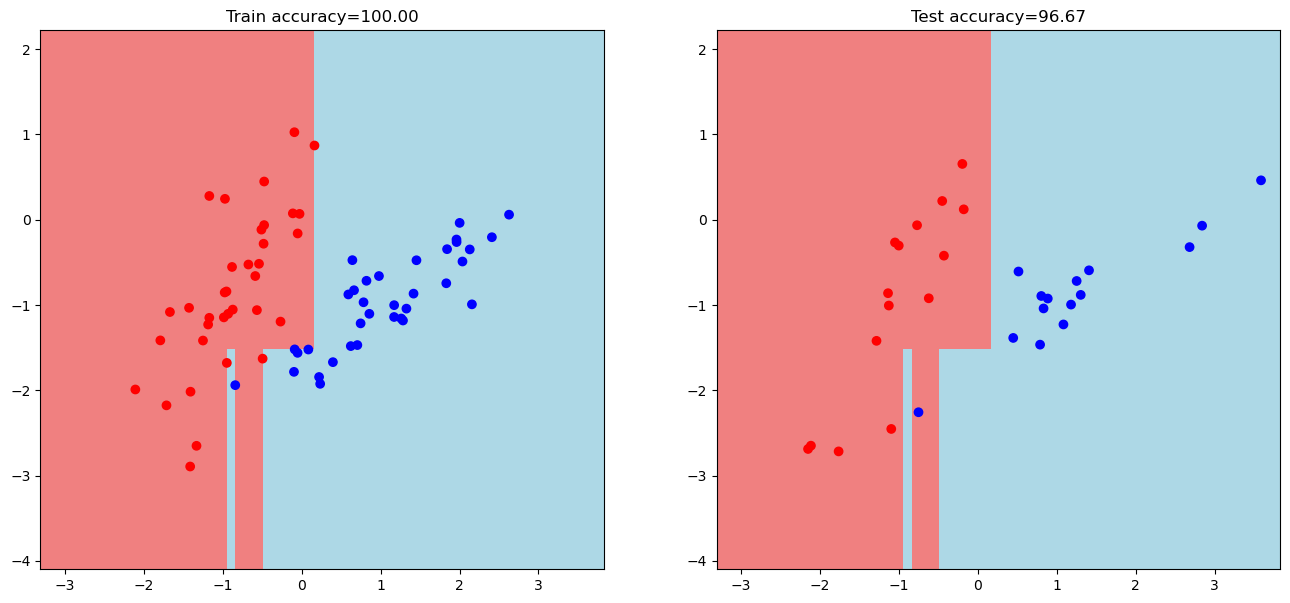

In [ ]:
%%time
visualize(train_data, test_data)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(train_data, train_labels)

train_answers = dt.predict(train_data)
test_answers = dt.predict(test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 100.0
Test accuracy 100.0


In [ ]:
accuracy_score(train_answers, train_labels) * 100

100.0

## Работа деревьев в случае пропущенных значений<a class='anchor' id='nan'>

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j} \leq t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз веорятности отнесения объекта $x$ к одному из классов.

**Добавим в выборку пропущенные значения**

In [ ]:
random_indices = np.random.randint(0, df.shape[0], 1000)
df.loc[random_indices, ['height']] = np.nan
df.isna().sum()

age       0
gender    0
height    5
cardio    0
dtype: int64

**Получим значения критерия Джини**

In [ ]:
root_gini = gini(df['cardio'])
root_gini

0.48

In [ ]:
t = df['height'].median()

df_clean = df[~df['height'].isna()]

In [ ]:
df1 = df_clean[df_clean['height'] <= t]
df2 = df_clean[df_clean['height'] > t]

In [ ]:
gini1 = gini(df1['cardio'])
gini2 = gini(df2['cardio'])
gini1, gini2

(0.48, 0.48)

**Получим значение прироста информации**

In [ ]:
current_gain = gain(df1['cardio'], df2['cardio'], root_gini, gini)
current_gain

0.0

**Сделаем поправку на потерю информации**

In [ ]:
df_clean.shape[0] / df.shape[0] * current_gain

0.0

**Если разбиение лучшее, то наблюдения с nan добавляются в обе ветки**

In [ ]:
df1 = df1.append(df[df['height'].isna()])
df2 = df2.append(df[df['height'].isna()])

## Работа деревьев с категориальными признаками<a class='anchor' id='cats'>

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

**Для классификации**

In [ ]:
colors = ['gray', 'blue', 'green']
new_feature = []
for i in range(df.shape[0]):
    new_feature.append(np.random.choice(colors, p=['0.5', '0.2', '0.3']))

df['eye_color'] = new_feature

df

,age,gender,height,cardio,eye_color
0,50,2,NaN,0,gray
1,55,1,NaN,1,gray
2,51,1,NaN,1,gray
3,48,2,NaN,1,gray
4,47,1,NaN,0,gray


In [ ]:
df[df['cardio'] == 1]['eye_color'].value_counts()

gray    3
Name: eye_color, dtype: int64

In [ ]:
df['eye_color'].replace({'gray': 3, 'green': 2, 'blue': 1})

0    3
1    3
2    3
3    3
4    3
Name: eye_color, dtype: int64

**Для регрессии**

In [ ]:
df.groupby('eye_color').mean()['age'].sort_values(ascending=False)

eye_color
gray    50.2
Name: age, dtype: float64

In [ ]:
df['eye_color'].replace({'gray': 3, 'green': 2, 'blue': 1})

0    3
1    3
2    3
3    3
4    3
Name: eye_color, dtype: int64

## Домашнее задание<a class='anchor' id='hw'>

1. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в файле "trees", заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
4. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
5. [Плейлист деревья решений](https://youtube.com/playlist?list=PLkJJmZ1EJno5eV954-PwtRJAw2lE6s-w1)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации неопределенности узла
* Вопросы для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)

### Определения
*Дерево решений*

**Дерево решений** — это математическая модель в виде графа, которая отображает точки принятия решений, предшествующие им события и последствия.

**Вершина** — узел, показывающий решение, которое нужно принять.

**Лист** — терминальный узел, показывающий конечный результат пути решения.

**Энтропия** — мера неопределённости некоторой системы.

**Прирост информации** — величина обратная энтропии, чем выше прирост информации, тем меньше энтропия, меньше неучтенных данных и лучше решение.